In [57]:
import os
import pickle
import sys
import datetime
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from hydra import initialize, compose
from glob import glob
from copy import deepcopy
import PIL
import matplotlib.patches as patches
import galsim
from galsim import roman
from galsim import InterpolatedImage, Image
import webbpsf
from skimage import restoration
from astropy import convolution

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input, psf

In [58]:
output_dir = os.path.join(array_dir, 'scenes_across_detectors')
util.create_directory_if_not_exists(output_dir)

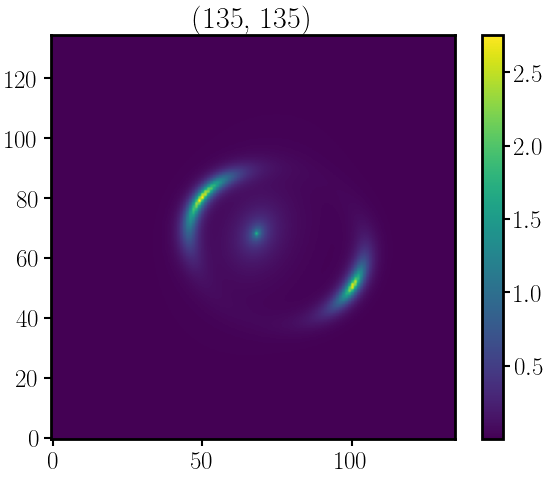

In [59]:
lens = SampleStrongLens()

num_pix = 45
side = 4.95
band = 'F184'
filter_name = band
exposure_time = 146
oversample_factor = 3

# add CDM subhalos
lens.add_subhalos(*pyhalo.unpickle_subhalos(os.path.join(pickle_dir, 'pyhalo', 'cdm_subhalos_tuple')))

model = lens.get_array(num_pix=45 * oversample_factor, side=4.95, band=band)
plot.plot(model, colorbar=True, title=model.shape)

In [60]:
roman_filters = roman.getBandpasses(AB_zeropoint=True)
pprint(roman_filters)
bandpass = roman_filters[filter_name]

ra_targ = galsim.Angle.from_hms('16:01:41.01257')
dec_targ = galsim.Angle.from_dms('66:48:10.1312')
targ_pos = galsim.CelestialCoord(ra=ra_targ, dec=dec_targ)

date = datetime.datetime(2025, 5, 16)

{'F184': galsim.Bandpass(galsim.LookupTable(x=array([1605.0, 1620.0, 1630.0, 1635.0, 1640.0, 1645.0, 1650.0, 1655.0, 1660.0, 1665.0, 1670.0, 1675.0, 1680.0, 1685.0, 1690.0, 1695.0, 1700.0, 1705.0, 1710.0, 1715.0, 1720.0, 1725.0, 1730.0, 1735.0, 1740.0, 1745.0, 1750.0, 1755.0, 1765.0, 1775.0, 1785.0, 1795.0, 1805.0, 1810.0, 1835.0, 1840.0, 1845.0, 1850.0, 1855.0, 1860.0, 1865.0, 1895.0, 1900.0, 1905.0, 1910.0, 1925.0, 1935.0, 1940.0, 1945.0, 1950.0, 1955.0, 1960.0, 1965.0, 1970.0, 1975.0, 1980.0, 1985.0, 1990.0, 1995.0, 2005.0, 2009.9999999999998, 2015.0000000000002, 2020.0, 2025.0, 2029.9999999999998, 2035.0000000000002, 2040.0, 2045.0, 2050.0, 2055.0, 2060.0, 2065.0, 2075.0, 2090.0]), f=array([0.0, 0.0004, 0.0023, 0.0047, 0.0092, 0.0169, 0.0295, 0.0486, 0.0759, 0.11240000000000001, 0.1582, 0.2121, 0.2716, 0.3334, 0.3937, 0.44909999999999994, 0.497, 0.5369, 0.5682, 0.5917, 0.6087, 0.6208, 0.6294, 0.6356, 0.6401, 0.6435, 0.6458, 0.6469, 0.6472, 0.6457, 0.6426, 0.6383, 0.6329, 0.6298, 0.

In [61]:
# get flux
total_flux_cps = lens.get_total_flux_cps(band)
print(total_flux_cps)

# get interpolated image
interp = InterpolatedImage(Image(model), scale=0.11 / oversample_factor, flux=total_flux_cps * exposure_time)

interp_05 = deepcopy(interp)
interp_09 = deepcopy(interp)
interp_11 = deepcopy(interp)
interp_12 = deepcopy(interp)
interp_16 = deepcopy(interp)

326.189283337688


In [62]:
# get kernels
pos_05 = galsim.PositionD(1024, 3072)  # 1024, 3072
psf_sca05 = roman.getPSF(4, SCA_pos=pos_05, bandpass=None, wavelength=bandpass, pupil_bin=1)  # 5

pos_09 = galsim.PositionD(4, 4)
psf_sca09 = roman.getPSF(9, SCA_pos=pos_09, bandpass=None, wavelength=bandpass, pupil_bin=1)

pos_11 = galsim.PositionD(4, 4092)
psf_sca11 = roman.getPSF(11, SCA_pos=pos_11, bandpass=None, wavelength=bandpass, pupil_bin=1)

pos_12 = galsim.PositionD(3072, 1024)
psf_sca12 = roman.getPSF(12, SCA_pos=pos_12, bandpass=None, wavelength=bandpass, pupil_bin=1)

pos_16 = galsim.PositionD(4092, 4092)
psf_sca16 = roman.getPSF(16, SCA_pos=pos_16, bandpass=None, wavelength=bandpass, pupil_bin=1)

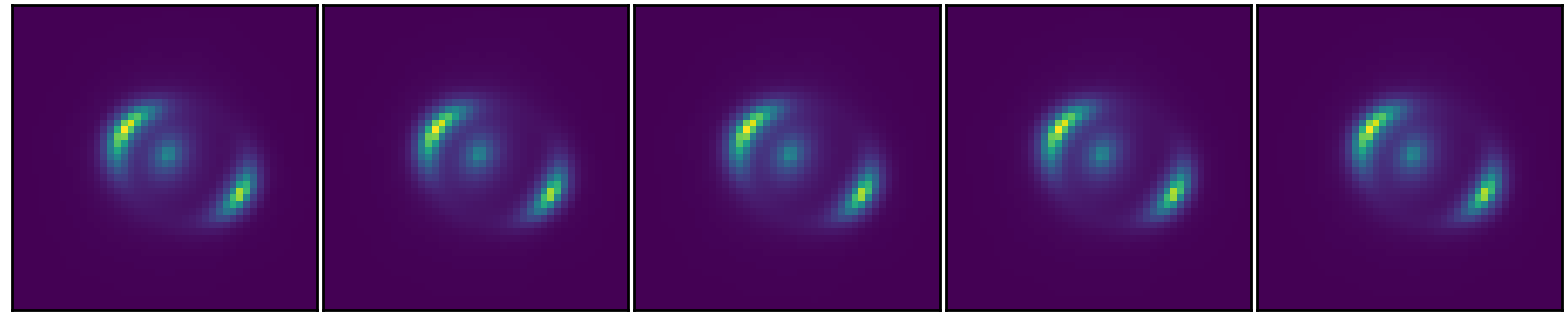

In [63]:
convolved_05 = galsim.Convolve(interp_05, psf_sca05)
convolved_09 = galsim.Convolve(interp_09, psf_sca09)
convolved_11 = galsim.Convolve(interp_11, psf_sca11)
convolved_12 = galsim.Convolve(interp_12, psf_sca12)
convolved_16 = galsim.Convolve(interp_16, psf_sca16)

# draw interpolated images
im05 = galsim.ImageF(45, 45, scale=0.11)
im09 = galsim.ImageF(45, 45, scale=0.11)
im11 = galsim.ImageF(45, 45, scale=0.11)
im12 = galsim.ImageF(45, 45, scale=0.11)
im16 = galsim.ImageF(45, 45, scale=0.11)

im05.setOrigin(0, 0)
im09.setOrigin(0, 0)
im11.setOrigin(0, 0)
im12.setOrigin(0, 0)
im16.setOrigin(0, 0)

image_05 = convolved_05.drawImage(im05).array
image_09 = convolved_09.drawImage(im09).array
image_11 = convolved_11.drawImage(im11).array
image_12 = convolved_12.drawImage(im12).array
image_16 = convolved_16.drawImage(im16).array

# convert to e-/sec from e- total
image_05 /= exposure_time
image_09 /= exposure_time
image_11 /= exposure_time
image_12 /= exposure_time
image_16 /= exposure_time

plot.plot_list([image_05, image_09, image_11, image_12, image_16])

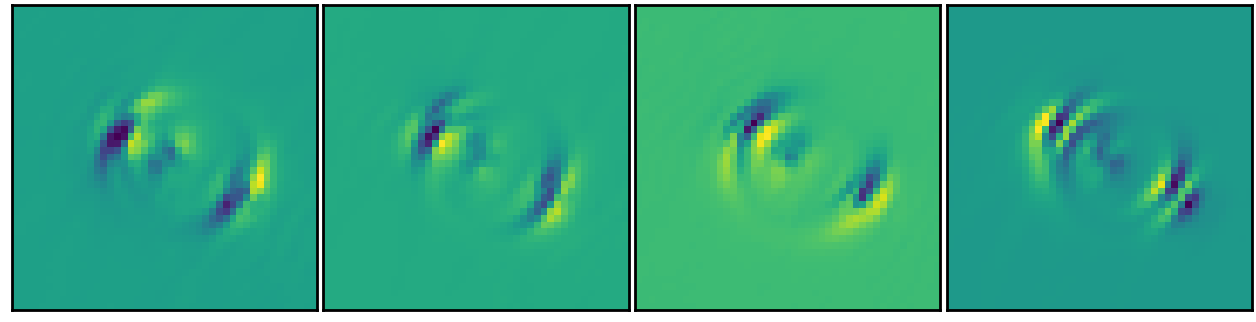

In [64]:
residual_05 = image_11 - image_05
residual_09 = image_11 - image_09
residual_12 = image_11 - image_12
residual_16 = image_11 - image_16

residual_list = [residual_05, residual_09, residual_12, residual_16]

plot.plot_list(residual_list)

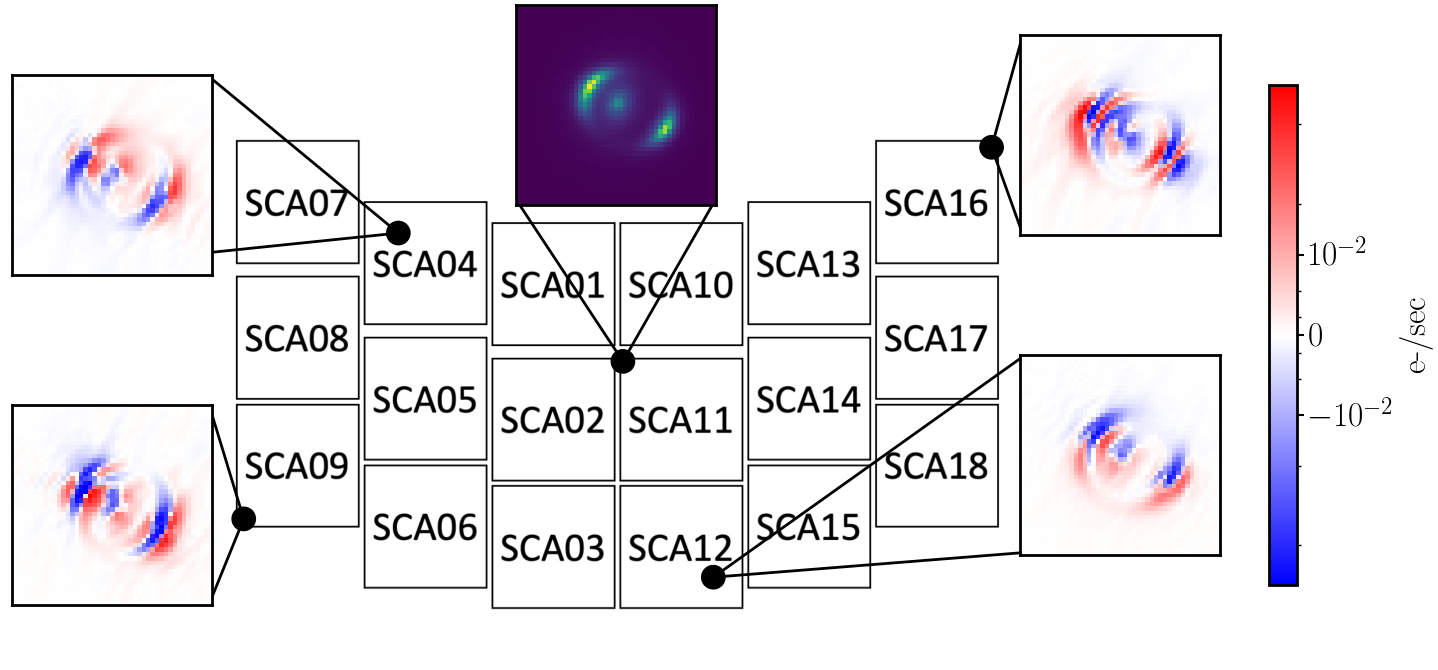

In [71]:
f, ax = plt.subplots(figsize=(14, 10))

fontsize = 24
matplotlib.rcParams.update({'font.size': fontsize})

fov = np.asarray(PIL.Image.open('../graphics/roman_fov.png'))
ax.imshow(fov, origin='upper')
ax.set_axis_off()

norm = plot_util.get_norm(residual_list, linear_width=0.01)

circ_05_coords = (535, 305)
circ_05 = patches.Circle(circ_05_coords, radius=20, color='black')
point_05 = ax.add_patch(circ_05)
ax_05 = f.add_axes([0.015,0.58,0.2,0.2], anchor='NE', zorder=1)
im = ax_05.imshow(residual_05, cmap='bwr', norm=norm)
ax_05.spines[:].set_linewidth(2.)
ax_05.set_xticks([])
ax_05.set_yticks([])
con_05_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_05.transData, xyB=circ_05_coords, coordsB=ax.transData)
con_05_b.set_linewidth(2)
con_05_t = patches.ConnectionPatch(xyA=(44,44), coordsA=ax_05.transData, xyB=circ_05_coords, coordsB=ax.transData)
con_05_t.set_linewidth(2)
ax.add_artist(con_05_b)
ax.add_artist(con_05_t)

circ_09_coords = (270, 795)
circ_09 = patches.Circle(circ_09_coords, radius=20, color='black')
point_09 = ax.add_patch(circ_09)
ax_09 = f.add_axes([0.015,0.25,0.2,0.2], anchor='NE', zorder=1)
ax_09.imshow(residual_09, cmap='bwr', norm=norm)
ax_09.spines[:].set_linewidth(2.)
ax_09.set_xticks([])
ax_09.set_yticks([])
con_09_b = patches.ConnectionPatch(xyA=(44,0), coordsA=ax_09.transData, xyB=circ_09_coords, coordsB=ax.transData)
con_09_b.set_linewidth(2)
con_09_t = patches.ConnectionPatch(xyA=(44,44), coordsA=ax_09.transData, xyB=circ_09_coords, coordsB=ax.transData)
con_09_t.set_linewidth(2)
ax.add_artist(con_09_b)
ax.add_artist(con_09_t)

circ_11_coords = (920, 525)
circ_11 = patches.Circle(circ_11_coords, radius=20, color='black')
point_11 = ax.add_patch(circ_11)
ax_11 = f.add_axes([0.375,0.65,0.2,0.2], anchor='NE', zorder=1)
ax_11.imshow(image_11, cmap='viridis')
ax_11.spines[:].set_linewidth(2.)
ax_11.set_xticks([])
ax_11.set_yticks([])
con_11_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_11.transData, xyB=circ_11_coords, coordsB=ax.transData)
con_11_b.set_linewidth(2)
con_11_t = patches.ConnectionPatch(xyA=(44,0), coordsA=ax_11.transData, xyB=circ_11_coords, coordsB=ax.transData)
con_11_t.set_linewidth(2)
ax.add_artist(con_11_b)
ax.add_artist(con_11_t)

circ_12_coords = (1075, 895)
circ_12 = patches.Circle(circ_12_coords, radius=20, color='black')
point_12 = ax.add_patch(circ_12)
ax_12 = f.add_axes([0.735,0.3,0.2,0.2], anchor='NE', zorder=1)
ax_12.imshow(residual_12, cmap='bwr', norm=norm)
ax_12.spines[:].set_linewidth(2.)
ax_12.set_xticks([])
ax_12.set_yticks([])
con_12_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_12.transData, xyB=circ_12_coords, coordsB=ax.transData)
con_12_b.set_linewidth(2)
con_12_t = patches.ConnectionPatch(xyA=(0,44), coordsA=ax_12.transData, xyB=circ_12_coords, coordsB=ax.transData)
con_12_t.set_linewidth(2)
ax.add_artist(con_12_b)
ax.add_artist(con_12_t)

circ_16_coords = (1552, 158)
circ_16 = patches.Circle(circ_16_coords, radius=20, color='black')
point_16 = ax.add_patch(circ_16)
ax_16 = f.add_axes([0.735,0.62,0.2,0.2], anchor='NE', zorder=1)
ax_16.imshow(residual_16, cmap='bwr', norm=norm)
ax_16.spines[:].set_linewidth(2.)
ax_16.set_xticks([])
ax_16.set_yticks([])
con_16_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_16.transData, xyB=circ_16_coords, coordsB=ax.transData)
con_16_b.set_linewidth(2)
con_16_t = patches.ConnectionPatch(xyA=(0,44), coordsA=ax_16.transData, xyB=circ_16_coords, coordsB=ax.transData)
con_16_t.set_linewidth(2)
ax.add_artist(con_16_b)
ax.add_artist(con_16_t)

cax = f.add_axes([0.97, 0.27, 0.02, 0.5])
cbar = f.colorbar(im, cax=cax, ticks=[-10 ** -1, -10** -2, 0, 10 ** -2, 10 ** -1])
cbar.set_label('e-/sec', rotation=90)

plt.savefig(os.path.join(figure_dir, 'scenes_across_detectors.png'))
plt.show()